In [24]:
import os
# This can make the kernel die if it doesn't go well
os.environ['R_HOME'] = "C:\Program Files\R\R-4.1.0"
from rpy2.robjects.packages import importr
r_utils = importr('utils')

In [25]:
# r_utils.install_packages('coda')

In [26]:
r_coda = importr('coda')

In [27]:
import pandas as pd

import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()

r_coda = importr('coda')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from scipy.special import expit

In [28]:
pd.set_option('display.max_colwidth', -1)

C:\Users\zkirsan\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [29]:
import nltk
#nltk.download('stopwords')

In [30]:
import re
from matplotlib import gridspec
import math
from sklearn.metrics import accuracy_score

### Part 1: Elon Musk's Tweets

In the first part of this project, we will be working with text from the @elonmusk Twitter account. This consists of all tweets from the account from 1/6/2010 to 1/6/2020. The goal is to use Latent Dirichlet Allocation in order to model the topics tweeted from Elon Musk.


In [31]:
df_tweets_orig = pd.read_csv('data/tweets_data_2010_2020.csv')

In [32]:
df_tweets = df_tweets_orig.copy()

In [33]:
df_tweets.head(10)

,date,text,tokenized_text,like_count,reply_count,retweet_count
0,2011-12-01,"{I made the volume on the Model S http://t.co/wMCnT53M go to 11. Now I just need to work in a miniature Stonehenge..., Went to Iceland on Sat to ride bumper cars on ice! No, not the country, Vlad's rink in Van Nuys. Awesome family fun :) http://t.co/rBQXJ9IT}","['made', 'volume', 'model', 'go', 'need', 'work', 'miniature', 'stonehenge', 'went', 'iceland', 'sat', 'ride', 'bumper', 'cars', 'ice', 'country', 'vladrink', 'van', 'nuys', 'awesome', 'family', 'fun']",267,63,24
1,2011-12-03,"{That was a total non sequitur btw, Great Voltaire quote, arguably better than Twain. Hearing news of his own death, Voltaire replied the reports were true, only premature.}","['total', 'non', 'sequitur', 'great', 'voltaire', 'quote', 'arguably', 'better', 'twain', 'hearing', 'news', 'death', 'voltaire', 'replied', 'reports', 'true', 'premature']",82,38,31
2,2011-12-04,{Am reading a great biography of Ben Franklin by Isaacson. Highly recommended.},"['reading', 'great', 'biography', 'ben', 'franklin', 'isaacson', 'highly', 'recommended']",65,17,9
3,2011-12-21,"{Yum! Even better than deep fried butter: http://t.co/Ody21NuD, Yeah, this really is me, as my Mom @mayemusk will attest. Not sure I can handle just doing 140 char missives. Will put longer thoughts on G+, Got called randomly by Kanye West today and received a download of his thoughts, ranging from shoes to Moses. He was polite, but opaque., His singing and acting talent will be sorely missed: http://t.co/IIFKob75 South Park sequel coming soon..., Why does the crowd cry over the glorious leader Kim Il Sung's death? Fear of being shot may play a role: http://t.co/hoQrYtG1, Sam Harris also wrote a nice piece on the awesomeness of Hitchens: http://t.co/fPkLiK3v May the good man RIP., Read ""Lying"", the new book by my friend Sam Harris. Excellent cover art and lots of good reasons not to lie!}","['yum', 'even', 'better', 'deep', 'fried', 'butter', 'yeah', 'really', 'mom', 'mayemusk', 'attest', 'sure', 'handle', 'char', 'missives', 'put', 'longer', 'thoughts', 'got', 'called', 'randomly', 'kanye', 'west', 'today', 'received', 'download', 'thoughts', 'ranging', 'shoes', 'moses', 'polite', 'opaque', 'singing', 'acting', 'talent', 'sorely', 'missed', 'south', 'park', 'sequel', 'coming', 'soon', 'crowd', 'cry', 'glorious', 'leader', 'il', 'fear', 'shot', 'may', 'play', 'role', 'sam', 'harris', 'wrote', 'nice', 'piece', 'awesomeness', 'hitchens', 'may', 'good', 'man', 'rip', 'read', 'lying', 'new', 'book', 'friend', 'sam', 'harris', 'excellent', 'cover', 'art', 'lots', 'good', 'reasons', 'lie']",1330,87,597
4,2011-12-22,"{Model S options are out! Performance in red and black for me. I will deliver my car in June/July. http://t.co/acnyP4nh, Hi, I'm Art Garfunkel. Have you heard the sound of silence? Because, you know, it makes a sound... http://t.co/7vgya9xL, Raul Campos invited me to do a guest DJ gig on KCRW. Hear my random holiday season music selections at http://t.co/o6FQASvC}","['model', 'options', 'performance', 'red', 'black', 'deliver', 'car', 'hi', 'iart', 'garfunkel', 'heard', 'sound', 'know', 'makes', 'sound', 'raul', 'campos', 'invited', 'guest', 'dj', 'gig', 'kcrw', 'hear', 'random', 'holiday', 'season', 'music', 'selections']",1349,132,206
5,2011-12-24,"{The Russians are having some challenges with their rockets. Too many of the engineers that designed them have retired: http://t.co/rEs7spSU, We had a long and interesting conversation on many subjects. He has exciting ideas for extending his creative talents beyond music., Kanye stopped by the SpaceX rocket factory today. http://t.co/6z7gHBn6}","['russians', 'challenges', 'rockets', 'many', 'engineers', 'designed', 'retired', 'long', 'interesting', 'conversation', 'many', 'subjects', 'exciting', 'ideas', 'extending', 'creative', 'talents', 'beyond', 'music', 'kanye', 'stopped', 'spacex', 'rocket', 'factory', 'today']",117113,1370,8434
6,2011-12-26,"{Walked aroun

In [34]:
df_tweets.dtypes 

date              object
text              object
tokenized_text    object
like_count        int64 
reply_count       int64 
retweet_count     int64 
dtype: object

In [35]:
df_tweets.shape

(1719, 6)

In [36]:
df_tweets['preprocessed_text'] = df_tweets.text.str.lower()

In [37]:
en_stop_words = set(stopwords.words('english'))
list(en_stop_words)[:10]

['against',
 'didn',
 "you've",
 "weren't",
 'nor',
 'needn',
 'once',
 "didn't",
 'than',
 'don']

In [38]:
df_tweets.preprocessed_text = df_tweets.preprocessed_text.apply(lambda row: ' '.join([word for word in row.split() if word not in (en_stop_words)]))

In [39]:
tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')

In [40]:
df_tweets['tokenized_text'] = df_tweets.preprocessed_text.apply(lambda row: tokenizer.tokenize(row))

In [41]:
df_tweets.head(1)

,date,text,tokenized_text,like_count,reply_count,retweet_count,preprocessed_text
0,2011-12-01,"{I made the volume on the Model S http://t.co/wMCnT53M go to 11. Now I just need to work in a miniature Stonehenge..., Went to Iceland on Sat to ride bumper cars on ice! No, not the country, Vlad's rink in Van Nuys. Awesome family fun :) http://t.co/rBQXJ9IT}","[made, volume, model, http, co, wmcnt53m, go, need, work, miniature, stonehenge, went, iceland, sat, ride, bumper, cars, ice, no, country, vlad's, rink, van, nuys, awesome, family, fun, http, co, rbqxj9it]",267,63,24,"{i made volume model http://t.co/wmcnt53m go 11. need work miniature stonehenge..., went iceland sat ride bumper cars ice! no, country, vlad's rink van nuys. awesome family fun :) http://t.co/rbqxj9it}"


In [42]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]

In [43]:
get_most_freq_words([ word for tweet in df_tweets.tokenized_text for word in tweet],10)

[('co', 1834),
 ('https', 1421),
 ('tesla', 640),
 ('amp', 573),
 ('http', 412),
 ('model', 260),
 ('spacex', 245),
 ('good', 183),
 ('launch', 174),
 ('rocket', 166)]

In [44]:
## the function below takes the original tweets dataframe, the column containing the tweet text, the dictionary of stop words
## it return a clean dataframe and a list of nb most frequent words, or all if None

def clean_tweets(df=df_tweets_orig, 
                 tweet_col='text', 
                 date_col='date',
                 stop_words=en_stop_words,
                 nb=None):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    # calculate word frequencies
    word_freqs = get_most_freq_words([ word for tweet in df_copy['tokenized_' + tweet_col] for word in tweet],nb)
    
    return word_freqs, df_copy

In [45]:
extended_stop_words = en_stop_words | \
                      {
                          'amp', 'rt', 'th','co', 're', 've', 'kim', 'daca', 'us', 'it', 'th', 'you', 'haha', 'st', 'et',
                          'so', 'iii', 'also', 've', 'la', 're', 'the', 'https', 'wow', 'actually', 'due', 'ft', 'pcr', 'via',
                          'am', 'gt', 'com', 'since', 'in', 'me', 'and', 'btw', 'yesterday', 'ii', 'inu', 'on', 'http', 'to', 
                          'vs', 'rd', 'ur', 'of', 'bs', 'km', 'est', 'em', 'lz', 'kms', 'aft', 'nd',  'here’s', 're',
                          'mqxfakpzf' 'mph', 'ht', 'etc', 'dm'
                      }

In [46]:
most_frequent_words, df_tweets_clean = clean_tweets(stop_words=extended_stop_words, nb=None)

In [47]:
most_frequent_words[:15]

[('tesla', 640),
 ('amp', 573),
 ('model', 260),
 ('spacex', 245),
 ('good', 183),
 ('launch', 174),
 ('rocket', 166),
 ('car', 163),
 ('falcon', 162),
 ('like', 151),
 ('time', 129),
 ('it', 127),
 ('first', 126),
 ('dragon', 118),
 ('great', 117)]

In [48]:
df_tweets_clean.head()

,date,text,tokenized_text,like_count,reply_count,retweet_count,preprocessed_text
0,2011-12-01,"{I made the volume on the Model S http://t.co/wMCnT53M go to 11. Now I just need to work in a miniature Stonehenge..., Went to Iceland on Sat to ride bumper cars on ice! No, not the country, Vlad's rink in Van Nuys. Awesome family fun :) http://t.co/rBQXJ9IT}","[made, volume, model, go, need, work, miniature, stonehenge, went, iceland, sat, ride, bumper, cars, ice, no, country, vlad's, rink, van, nuys, awesome, family, fun]",267,63,24,"{i made volume model go 11. need work miniature stonehenge..., went iceland sat ride bumper cars ice! no, country, vlad's rink van nuys. awesome family fun :)"
1,2011-12-03,"{That was a total non sequitur btw, Great Voltaire quote, arguably better than Twain. Hearing news of his own death, Voltaire replied the reports were true, only premature.}","[that, total, non, sequitur, btw, great, voltaire, quote, arguably, better, twain, hearing, news, death, voltaire, replied, reports, true, premature]",82,38,31,"{that total non sequitur btw, great voltaire quote, arguably better twain. hearing news death, voltaire replied reports true, premature.}"
2,2011-12-04,{Am reading a great biography of Ben Franklin by Isaacson. Highly recommended.},"[am, reading, great, biography, ben, franklin, isaacson, highly, recommended]",65,17,9,{am reading great biography ben franklin isaacson. highly recommended.}
3,2011-12-21,"{Yum! Even better than deep fried butter: http://t.co/Ody21NuD, Yeah, this really is me, as my Mom @mayemusk will attest. Not sure I can handle just doing 140 char missives. Will put longer thoughts on G+, Got called randomly by Kanye West today and received a download of his thoughts, ranging from shoes to Moses. He was polite, but opaque., His singing and acting talent will be sorely missed: http://t.co/IIFKob75 South Park sequel coming soon..., Why does the crowd cry over the glorious leader Kim Il Sung's death? Fear of being shot may play a role: http://t.co/hoQrYtG1, Sam Harris also wrote a nice piece on the awesomeness of Hitchens: http://t.co/fPkLiK3v May the good man RIP., Read ""Lying"", the new book by my friend Sam Harris. Excellent cover art and lots of good reasons not to lie!}","[yum, even, better, deep, fried, butter, yeah, really, me, mom, mayemusk, attest, sure, handle, char, missives, put, longer, thoughts, got, called, randomly, kanye, west, today, received, download, thoughts, ranging, shoes, moses, polite, opaque, singing, acting, talent, sorely, missed, south, park, sequel, coming, soon, crowd, cry, glorious, leader, il, sung's, death, fear, shot, may, play, role, sam, harris, wrote, nice, piece, awesomeness, hitchens, may, good, man, rip, read, lying, new, book, friend, sam, harris, excellent, cover, art, lots, good, reasons, lie]",1330,87,597,"{yum! even better deep fried butter: yeah, really me, mom @mayemusk attest. sure handle 140 char missives. put longer thoughts g+, got called randomly kanye west today received download thoughts, ranging shoes moses. polite, opaque., singing acting talent sorely missed: south park sequel coming soon..., crowd cry glorious leader il sung's death? fear shot may play role: sam harris wrote nice piece awesomeness hitchens: may good man rip., read ""lying"", new book friend sam harris. excellent cover art lots good reasons lie!}"
4,2011-12-22,"{Model S options are out! Performance in red and black for me. I will deliver my car in June/July. http://t.co/acnyP4nh, Hi, I'm Art Garfunkel. Have you heard the sound of silence? Because, you know, it makes a sound... http://t.co/7vgya9xL, Raul Campos invited me to do a guest DJ gig on KCRW. Hear my random holiday season music selections at http://t.co/o6FQASvC}","[model, options, out, performance, red, black, me, deliver, car, june, july, hi, art, garfunkel, heard, sound, silence, because, know, makes, sound, raul, campos, invited, guest, dj, gig, kcrw, hear, random, holiday, season, music, selections]"

Latent Dirichlet Allocation is the probabilistic transformation of a bag-of-words count into a lower-dimensional topic space. Tweets are viewed as a subject distribution. The distribution of all the terms in the vocabulary, in turn, represents topics. However, we don't know how many subjects are in the corpus or how many tweets each topic contains. With LDA, we wish to approach the topic assignment of tweets as a random variable that is estimated from the available data.

In [49]:
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

In [50]:
print("We have {} tweets and {} words in the dictionary.".format(df_tweets_clean.shape[0],len(tweets_dictionary)))

We have 1719 tweets and 8447 words in the dictionary.


In [51]:
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

It's an art to find the correct number of themes for LDA. Perplexity techniques are frequently preferred over Topic Coherence procedures. With coherence, we measure the degree of semantic similarity between a topic's high-scoring words to determine its coherence. As a result, more human-interpretable subjects emerge. The method chooses the most commonly used words in each topic. To determine the coherence score for a given topic, it computes and aggregates the pairwise scores (UMass) for each of the words.

In [52]:
tweets_coherence = []
for nb_topics in range(1,36):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)
    print(nb_topics,coh)

1 -2.4369486138563357
2 -2.5532795684645517
3 -2.6834662295711915
4 -2.7883540609594677
5 -2.7063743527314243
6 -2.9395372007589464
7 -2.909694577636242
8 -3.086517632191979
9 -3.484780177770087
10 -3.357041594330903
11 -3.6104621550092233
12 -3.8309132699236677
13 -3.3660304762635977
14 -3.7339409879035927
15 -3.7999679532703294
16 -4.052592946006019
17 -3.788669063518686
18 -3.8921583061099088
19 -4.175794448233874
20 -4.016829136928655
21 -4.061789698922613
22 -4.078154184079357
23 -4.261478384650918
24 -4.412307565049935
25 -4.689832184911197
26 -4.414340667089929
27 -4.087322105586177
28 -4.666035480570371
29 -4.746514452862188
30 -4.846546703492
31 -4.743185373008594
32 -5.093487132647342
33 -5.114386601046775
34 -4.890762397785176
35 -5.319477741639026


We visualize the average coherence score per topic for a range of models trained with a different number of topics below. The number of topics for which the average score plateaus, is the sweet spot we are looking for. So our best guess for the number of topics is around 22. We should consider that, typically a corpus with very short documents (tweets in our case) tends to be more difficult to apply to coherent models than a corpus with longer documents.

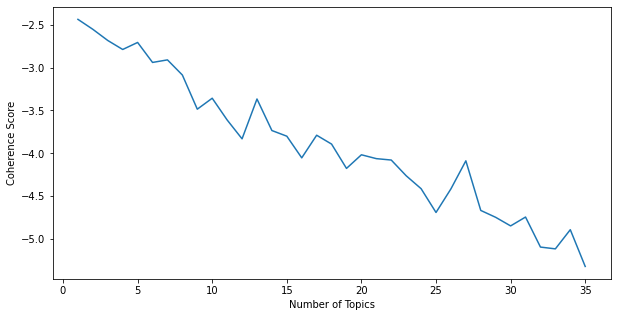

In [53]:
plt.figure(figsize=(10,5))
plt.plot(range(1,36),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

**Run LDA on the texts using the optimal value of $k$ found via the analysis above. Print out the top 10 words and associated betas for each of the $k$ topics. Comment on the results and their plausibility.**

In [54]:
k = 22
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

In [55]:
def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

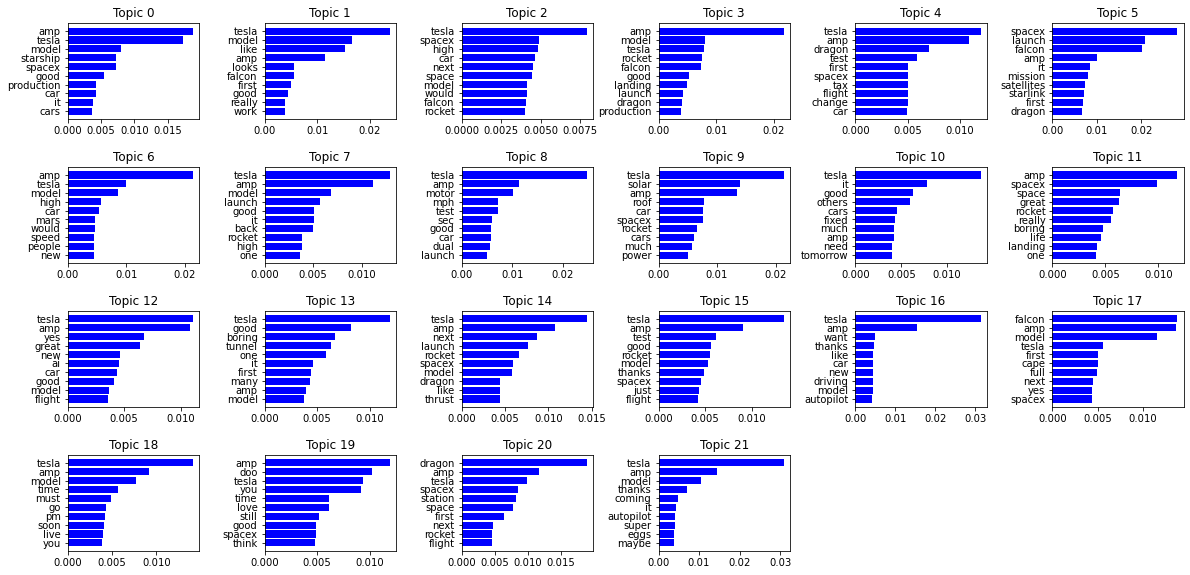

In [56]:
plot_top_words()

The topics do not make totally sense. However we can see the following meaningful match:

Topic 1 - tesla

Topic 5, - spaceX

etc